In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import collections

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1304,359,134,1958
2017-04-16,1463,335,187,2206
2017-04-17,1352,287,179,2003
2017-04-18,2766,382,317,3655
2017-04-19,3134,447,309,4117


In [6]:
'Average tweet number per day: {:.0f}'.format(timeline['total'].mean())

'Average tweet number per day: 3098'

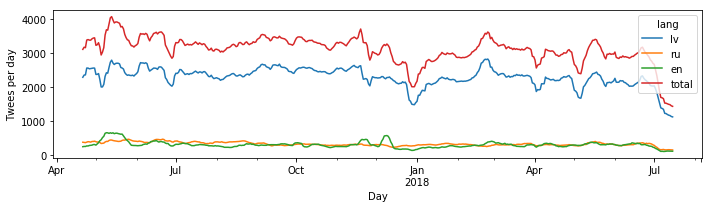

In [7]:
_ = (
    timeline
    .rolling(window=7).mean()
    .plot(figsize=(10, 3))
)

_.set(xlabel='Day', ylabel='Twees per day')


_.figure.tight_layout()
_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Source statistics

In [8]:
sources = (
    pd.read_csv(
        'rehydrated_tweets_source_counts.csv',
        index_col=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
        ],
        usecols=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
            'source_lang_count', 'source_lang_share'
        ],
    )
    .unstack('lang', fill_value=0)
)

In [9]:
sources = (
    sources.reorder_levels([1, 0], axis=1)
    .reset_index()
    .set_index('source_pretty').sort_values('total_count', ascending=False)[
        [
            'total_count', 'total_share', 'tracked_source_share',
            'lv', 'ru', 'en',
            'other_lang_count', 'other_lang_share',
        ]
    ]
    .sort_values('total_count', ascending=False)
)

In [10]:
sources

lang                total_count total_share tracked_source_share  \
                                                                   
source_pretty                                                      
Twitter Web Client       484547       34.2%                52.7%   
Twitter for Android      231631       16.4%                 8.5%   
Twitter for iPhone       212021       15.0%                14.6%   
TweetDeck                108826        7.7%                92.0%   
TVNET Login               61116        4.3%                96.6%   
dlvr.it                   47781        3.4%                98.4%   
Facebook                  38152        2.7%                95.1%   
Foursquare                31493        2.2%                 0.0%   
Instagram                 25774        1.8%                 1.8%   
SKATIES                   24184        1.7%                97.9%   

lang                               lv                                  ru  \
                    source_lang_count source_lang_share source_lang_count   
source_pretty                                                               
Twitter Web Client             400533             82.7%             15403   
Twitter for Android            157577             68.0%             22911   
Twitter for iPhone             127317             60.0%             34537   
TweetDeck                      106660             98.0%                76   
TVNET Login                     27634             45.2%             32750   
dlvr.it                         47209             98.8%               145   
Facebook                        14341             37.6%             22013   
Foursquare                      24853             78.9%               221   
Instagram                        9242             35.9%              2504   
SKATIES                         24166             99.9%                 0   

lang                                                 en                    \
                    source_lang_share source_lang_count source_lang_share   
source_pretty                                                               
Twitter Web Client               3.2%             40316              8.3%   
Twitter for Android              9.9%             33818             14.6%   
Twitter for iPhone              16.3%             32445             15.3%   
TweetDeck                        0.1%              1532              1.4%   
TVNET Login                     53.6%                26              0.0%   
dlvr.it                          0.3%               135              0.3%   
Facebook                        57.7%               462              1.2%   
Foursquare                       0.7%              1902              6.0%   
Instagram                        9.7%              8619             33.4%   
SKATIES                             0                 0                 0   

lang                other_lang_count other_lang_share  
                                                       
source_pretty                                          
Twitter Web Client             28295             5.8%  
Twitter for Android            17325             7.5%  
Twitter for iPhone             17722             8.4%  
TweetDeck                        558             0.5%  
TVNET Login                      706             1.2%  
dlvr.it                          292             0.6%  
Facebook                        1336             3.5%  
Foursquare                      4517            14.3%  
Instagram                       5409            21.0%  
SKATIES                           18             0.1%

In [11]:
sources.to_latex('figures/rehydrated_tweets_source_counts.tex')

# Users

In [12]:
rehydrated_tweets_user_tweet_count = pd.read_csv('rehydrated_tweets_user_tweet_count.csv', squeeze=True)

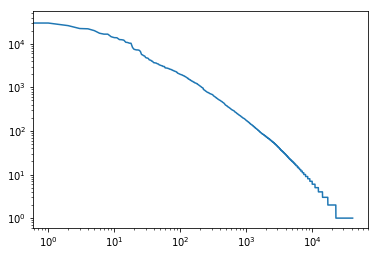

In [13]:
rehydrated_tweets_user_tweet_count.plot.line(logx=True, logy=True);

In [14]:
_total = rehydrated_tweets_user_tweet_count.shape[0]
_at_least_50 = (rehydrated_tweets_user_tweet_count >= 50).sum()
print(
    f'Total users: {_total}\n'
    f'Users with at least 50 tweets: {_at_least_50} ({{:.1%}})'.format(_at_least_50 / _total)
)

Total users: 41443
Users with at least 50 tweets: 2786 (6.7%)


In [15]:
active_tweets = rehydrated_tweets_user_tweet_count[rehydrated_tweets_user_tweet_count >= 50].sum()
total_tweets = rehydrated_tweets_user_tweet_count.sum()
assert timeline['total'].sum() == total_tweets
_ = active_tweets / total_tweets
f'Total tweets by active users: {active_tweets}, {_:.1%}. Total tweets: {total_tweets}'

'Total tweets by active users: 1229010, 86.8%. Total tweets: 1415984'

# Language usage 

In [16]:
rehydrated_tweets_language_counts = (
    pd.read_csv('rehydrated_tweets_language_counts.csv', index_col='lang')
)

In [17]:
rehydrated_tweets_language_counts

,count
lang,
en,138492
lv,1046412
ru,149366


In [18]:
(
    (rehydrated_tweets_language_counts / timeline['total'].sum())
    .style.format({'count': '{:.1%}'})
)

,count
lang,
en,9.8%
lv,73.9%
ru,10.5%


In [19]:
_ = (timeline['total'].sum() - rehydrated_tweets_language_counts.sum())[0]

__ = _ / rehydrated_tweets_language_counts.sum()[0]
f'{_}, {__:.1%}'

'81714, 6.1%'

In [20]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

In [21]:
'Users with at least 50 users (should match the value above): {}'.format(lang_usage.shape[0])

'Users with at least 50 users (should match the value above): 2786'

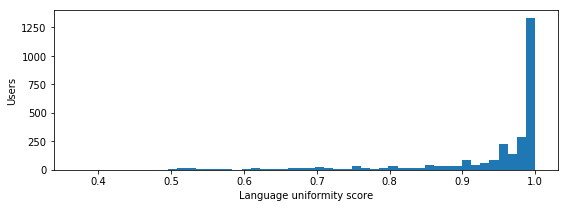

In [22]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=50, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [23]:
_ = pd.read_csv(
    'milajevs-bucc17-screen_names-languages.csv',
    index_col='Screen name',
    usecols=['Screen name', 'Latvian', 'Russian', 'English'],
).fillna(0).astype(int)

_.columns = ['lv', 'ru', 'en']

bucc17_uniformity_score = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

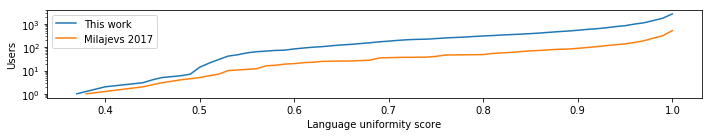

In [24]:
_ = (
    lang_usage['Language Uniformity Score'].value_counts().sort_index().cumsum().rename('This work')
    .plot(logx=False, logy=True, figsize=(10, 2), legend=True)
)

bucc17_uniformity_score.value_counts().sort_index().cumsum().rename('Milajevs 2017').plot(legend=True)

_.set(xlabel='Language uniformity score', ylabel='Users')
_.figure.tight_layout()

_.figure.savefig('uniformity_score.pdf')

In [25]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
2021,13,16,14,74,0.37
1610,16,20,14,97,0.40
2389,26,8,25,60,0.44
441,80,146,95,458,0.45
791,48,78,44,230,0.46


# Language preference

## Monolingual

In [26]:
monolingual = (
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

In [27]:
'Monoligual users: {}'.format(monolingual.sum())

'Monoligual users: 797'

In [28]:
pd.DataFrame(
    {
        'count': monolingual,
        'share': (monolingual / monolingual.sum()).round(3),
    }
)

,count,share
lv,643,0.807
ru,40,0.050
en,114,0.143


## Multilingual

In [29]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,1501,226,254
2.0,306,161,1554
3.0,75,230,99


# Topics

In [30]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

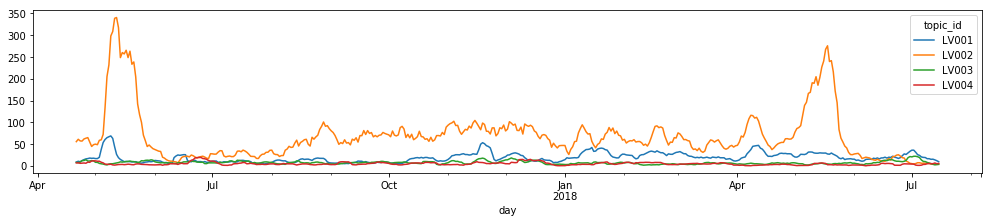

In [31]:
(
    relevance_judgments_count_by_day[
        ['LV001', 'LV002', 'LV003', 'LV004']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [32]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [33]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets           Users           
Language             Total lv, ru, en     lv   ru   en    lv   ru    en
day        topic_id                                                    
2017-04-16 LV001         8          8    1.0  0.0  0.0  0.99  0.0  0.01
2017-04-17 LV001         1          1    1.0  0.0  0.0  0.81  0.0  0.19
2017-04-18 LV001        12         12    1.0  0.0  0.0  0.98  0.0  0.02
2017-04-19 LV001        15         15    1.0  0.0  0.0  0.88  0.0  0.12
2017-04-20 LV001        11         10    1.0  0.0  0.0  1.00  0.0  0.00

In [34]:
relevance_judgments_lang_pref_by_day['Counts', 'Total'].groupby(level='topic_id').sum()

topic_id
LV001     7638
LV002    26719
LV003     3144
LV004     2123
LV005     7401
LV006     9391
LV007     1479
LV008     1207
LV009     2204
LV010      969
LV011      949
LV012     3485
LV013     1398
LV014      479
LV015      197
LV016      219
Name: (Counts, Total), dtype: int64

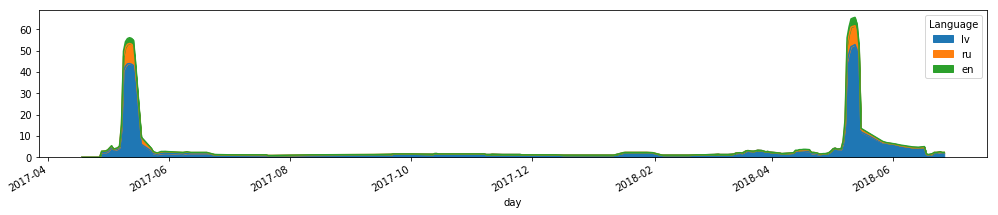

In [35]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV008'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [36]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day', 'tweet_lang'],
    parse_dates=['day']
)

relevance_judgments_lang_pref = _

In [37]:
relevance_judgments_lang_pref.loc[['LV001']].head()

r_lv  r_ru  r_en
topic_id day        tweet_lang                  
LV001    2018-01-24 lv          0.66  0.01  0.33
         2018-02-18 und         0.66  0.01  0.33
         2018-02-19 lv          0.66  0.01  0.33
         2018-02-26 lv          0.66  0.01  0.33
         2018-02-27 lv          0.66  0.01  0.33

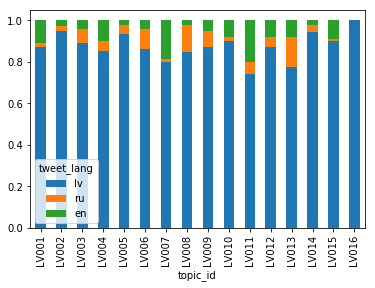

In [38]:
_ = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)

_total = _.sum(axis='columns')

__ = _.divide(_total, axis='rows')

__['total'] = _total
__.style.format({'lv': '{:.1%}', 'ru': '{:.1%}', 'en': '{:.1%}'})

__.to_latex('figures/topic_lang_counts.tex', float_format='{:.1%}'.format)

__[['lv', 'ru', 'en']].plot.bar(stacked=True);

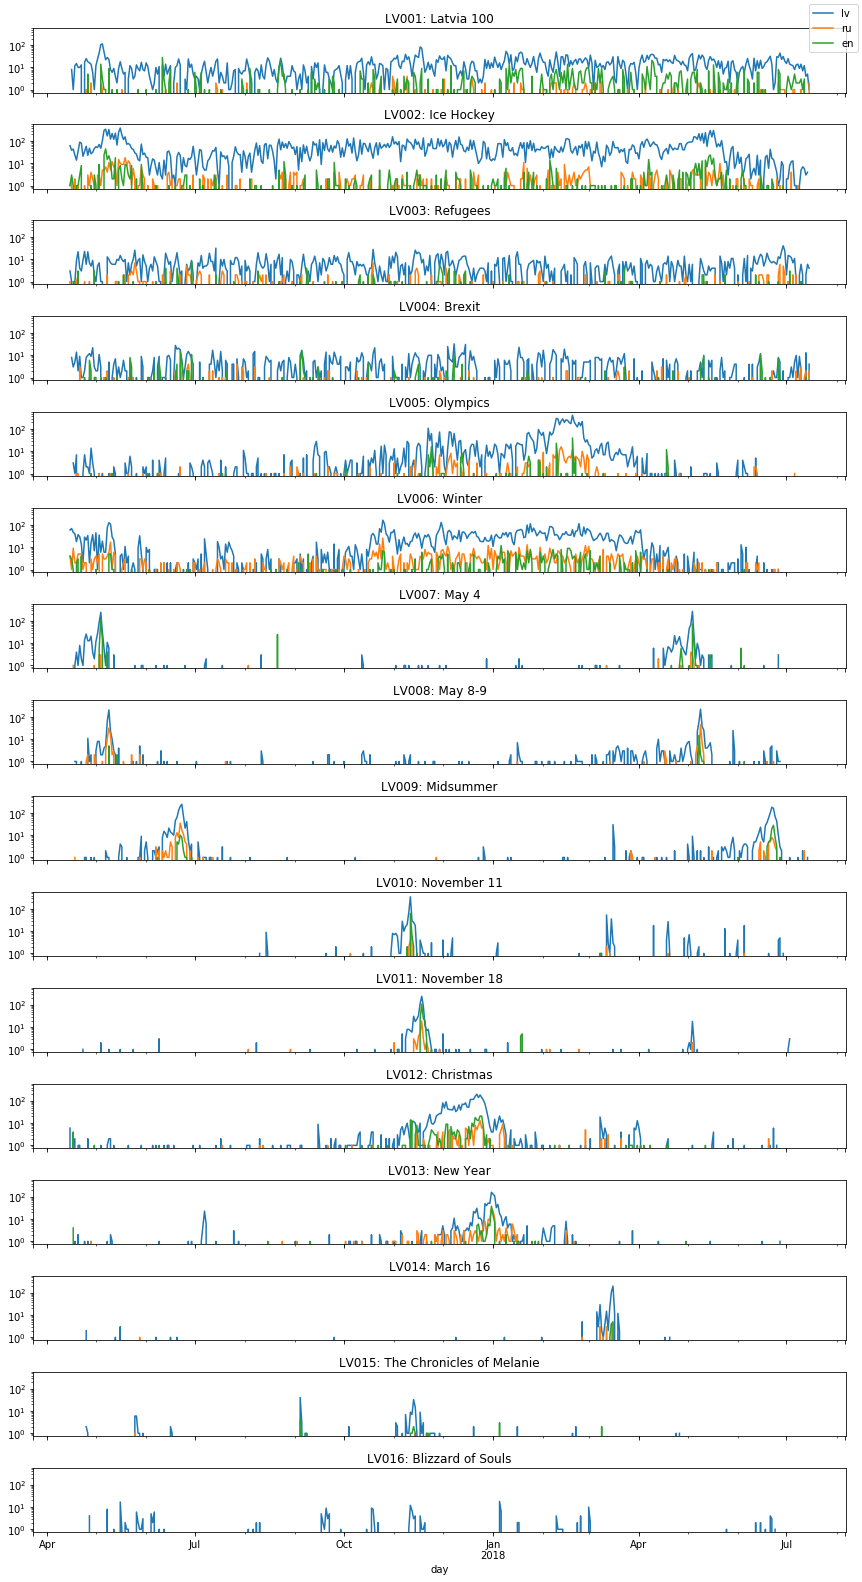

In [39]:
_data = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'day' ,'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)


topics = collections.OrderedDict(
    [

        ('LV001', 'Latvia 100'),
        ('LV002', 'Ice Hockey'),
        ('LV003', 'Refugees'),
        ('LV004', 'Brexit'),
        ('LV005', 'Olympics'),

        ('LV006', 'Winter'),

        ('LV007', 'May 4'),
        ('LV008', 'May 8-9'),
        ('LV009', 'Midsummer'),
        ('LV010', 'November 11'),
        ('LV011', 'November 18'),
        ('LV012', 'Christmas'),
        ('LV013', 'New Year'),
        ('LV014', 'March 16'),

        ('LV015', 'The Chronicles of Melanie'),
        ('LV016', 'Blizzard of Souls'),
 
     ]
)

fig, axs = plt.subplots(len(topics), 1, sharex=True, sharey=True, figsize=(12, 22))

axs = axs.flatten()


for (topic, topic_title), ax in zip (topics.items(), axs):

    _ = (
        _data.loc[topic]
        .resample('1d', level='day').sum()
        .plot.line(ax=ax, logy=True, legend=False, title=f'{topic}: {topic_title}')
    );

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.tight_layout()
fig.savefig('topic_timeline.pdf')

# Topic overlap

In [40]:
relevance_judgments_topic_overlap = (
    pd.read_csv('relevance_judgments_topic_overlap.csv')
    .groupby(['topic1', 'title1', 'topic2']).size().unstack('topic2', fill_value='')
)

In [41]:
relevance_judgments_topic_overlap

,topic2,LV001,LV002,LV003,LV004,LV005,LV006,LV007,LV008,LV009,LV010,LV011,LV012,LV013,LV014,LV015,LV016
topic1,title1,,,,,,,,,,,,,,,,
LV001,Latvia 100,8649,17,13,,29,2,134,18,14,26,60,7,6,,8,4
LV002,Ice Hockey,,30719,,,395,25,38,1,7,12,2,32,9,,,
LV003,Refugees,,,3336,30,,,,,2,,,11,1,,,
LV004,Brexit,,,,2223,,1,,,,,,,2,,,
LV005,Olympics,,,,,8570,13,,,,,,2,,,,
LV006,Winter,,,,,,10531,1,6,6,,10,236,42,,,
LV007,May 4,,,,,,,1863,8,,2,7,,,,,
LV008,May 8-9,,,,,,,,1389,1,1,,,,4,,
LV009,Midsummer,,,,,,,,,2604,,,3,1,1,,
